In [204]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import lightgbm_with_simple_features as lgbmsf
import json
import seaborn as sns
import re
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from imputer_selection import imputer_selection

with open('config.json', 'r') as f:
    config = json.load(f)
    
NUM_ROWS = config["NUM_ROWS"]

In [2]:
!ls -lrth ./data

total 6652280
-rw-r--r--@ 1 Olivier  staff   405M 26 jui  2018 credit_card_balance.csv
-rw-r--r--@ 1 Olivier  staff   358M 26 jui  2018 bureau_balance.csv
-rw-r--r--@ 1 Olivier  staff   375M 26 jui  2018 POS_CASH_balance.csv
-rw-r--r--@ 1 Olivier  staff    25M 26 jui  2018 application_test.csv
-rw-r--r--@ 1 Olivier  staff   162M 26 jui  2018 bureau.csv
-rw-r--r--@ 1 Olivier  staff   524K 26 jui  2018 sample_submission.csv
-rw-r--r--@ 1 Olivier  staff   690M 26 jui  2018 installments_payments.csv
-rw-r--r--@ 1 Olivier  staff   386M 26 jui  2018 previous_application.csv
-rw-r--r--@ 1 Olivier  staff   158M 26 jui  2018 application_train.csv
-rw-r--r--@ 1 Olivier  staff   688M 21 jan 21:06 Projet+Mise+en+prod+-+home-credit-default-risk.zip
-rw-r--r--@ 1 Olivier  staff    37K 24 jan 13:38 HomeCredit_columns_description.csv
-rw-r--r--@ 1 Olivier  staff    65K 25 jan 10:48 home_credit.png
-rw-r--r--  1 Olivier  staff   3,3K 28 jan 17:08 imputer_selection.py


# I. Exploration des datasets

Dans cette partie on explore les différents datasets. Dans la mesure où la mission ici est centrée sur le déploiement du modèle via une api et non sur la construction du modèle lui-même, on se reportera au kernel fourni dans les ressources du projet, et on ré-utilisera le feature engineering réalisé dans ce kernel. On se contentera d'analyser les features créées - statistiques univariées, corrélations via les statistiques bivariées, valeurs manquantes, possibilité de retirer des colonnes/imputer et finalement feature importance.

### application_train.csv
- This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
- Static data for all applications. One row represents one loan in our data sample.

In [159]:
application_train_df = pd.read_csv('./data/application_train.csv')
application_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
application_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


On prend la valeur absolue des variables DAYS_BIRTH, DAYS_EMPLOYED, DAYS_ID_PUBLISH

In [161]:
for col in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']:
    application_train_df[col] = np.abs(application_train_df[col])

In [162]:
application_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


**La fonction application_train_test du module lgbm_sf**

In [163]:
train_df_processed = lgbmsf.application_train_test(num_rows=NUM_ROWS)
train_df_processed.head()

Train samples: 15000


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0,1,0,1,0,0.067329,0.498036,202500.0,0.121978,0.060749
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,1,0,0.070862,0.208736,135000.0,0.132217,0.027598
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0.011814,0.500000,67500.0,0.100000,0.050000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0.159905,0.431748,67500.0,0.219900,0.094941
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0.152418,0.236842,121500.0,0.179963,0.042623


In [164]:
train_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 244 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: float64(71), int64(43), uint8(130)
memory usage: 15.0 MB


In [174]:
cat_cols = [col for col in train_df_processed.columns if train_df_processed[col].max()==1]
not_convert = []
for col in cat_cols:
    try:
        train_df_processed[col] = train_df_processed[col].astype('uint8')
    except:
        not_convert.append(col)
train_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 244 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: float64(71), int64(10), uint8(163)
memory usage: 11.7 MB


In [170]:
train_df_processed[cat_cols].describe()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.0,15000.000000,15000.000000,15000.000000,15000.0000,15000.000000,...,15000.000000,15000.000000,15000.00000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.078267,0.657000,0.337800,0.304133,1.0,0.821800,0.200867,0.998333,0.2812,0.054533,...,0.004133,0.032867,0.00720,0.005667,0.005400,0.217733,0.206667,0.016000,0.519933,0.007267
std,0.268600,0.474727,0.472976,0.460055,0.0,0.382694,0.400662,0.040792,0.4496,0.227075,...,0.064160,0.178293,0.08455,0.075066,0.073288,0.412719,0.404928,0.125479,0.499619,0.084937
min,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.0000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.0000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.0000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [176]:
train_df_processed[not_convert].describe()

,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE
count,7410.000000,6275.000000,7681.000000,5047.000000,4513.000000,7062.000000,7483.000000,7584.000000,4846.000000,6151.000000,...,7062.000000,7483.000000,7584.000000,4846.000000,6151.000000,4747.00000,7464.000000,4600.000000,6787.000000,7775.000000
mean,0.117091,0.089356,0.979109,0.750743,0.044069,0.077107,0.151030,0.224742,0.230621,0.067018,...,0.076590,0.150769,0.224316,0.230426,0.067999,0.10121,0.108436,0.008267,0.028509,0.101463
std,0.107392,0.082886,0.045614,0.112371,0.078463,0.134715,0.100448,0.144723,0.160273,0.082597,...,0.134967,0.100777,0.145151,0.160472,0.083887,0.09375,0.111907,0.044462,0.071924,0.105263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.058800,0.044700,0.976700,0.687200,0.007600,0.000000,0.069000,0.166700,0.083300,0.019150,...,0.000000,0.069000,0.166700,0.083300,0.019300,0.05130,0.046675,0.000000,0.000000,0.041800
50%,0.086600,0.076400,0.981600,0.755200,0.019800,0.000000,0.137900,0.166700,0.208300,0.047900,...,0.000000,0.137900,0.166700,0.208300,0.048600,0.07520,0.074900,0.000000,0.003000,0.068300
75%,0.146400,0.113300,0.986600,0.816400,0.050300,0.120000,0.206900,0.333300,0.375000,0.086200,...,0.120000,0.206900,0.333300,0.375000,0.087300,0.12230,0.128200,0.003900,0.026450,0.122700
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [177]:
float_cols = [col for col in train_df_processed.columns if train_df_processed[col].dtype=='float64']
train_df_processed[float_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 71 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AMT_INCOME_TOTAL              15000 non-null  float64
 1   AMT_CREDIT                    15000 non-null  float64
 2   AMT_ANNUITY                   15000 non-null  float64
 3   AMT_GOODS_PRICE               14989 non-null  float64
 4   REGION_POPULATION_RELATIVE    15000 non-null  float64
 5   DAYS_EMPLOYED                 12328 non-null  float64
 6   DAYS_REGISTRATION             15000 non-null  float64
 7   OWN_CAR_AGE                   5067 non-null   float64
 8   CNT_FAM_MEMBERS               15000 non-null  float64
 9   EXT_SOURCE_1                  6557 non-null   float64
 10  EXT_SOURCE_2                  14960 non-null  float64
 11  EXT_SOURCE_3                  11994 non-null  float64
 12  APARTMENTS_AVG                7410 non-null   float64
 13  B

In [152]:
train_df_processed[float_cols].describe()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
count,1.500000e+04,1.500000e+04,15000.000000,1.498900e+04,15000.000000,12328.000000,15000.000000,5067.000000,15000.000000,6557.000000,...,12974.000000,12974.000000,12974.000000,12974.000000,12974.000000,12328.000000,15000.000000,1.500000e+04,15000.000000,15000.000000
mean,1.756050e+05,6.013717e+05,27103.271700,5.408710e+05,0.020750,-2385.173507,-4974.038733,11.908427,2.165533,0.503055,...,0.008093,0.033220,0.274780,0.265377,1.874210,0.157198,0.411747,9.423652e+04,0.181710,0.053478
std,9.587758e+05,4.039823e+05,14448.807289,3.716996e+05,0.013793,2328.744516,3542.193270,11.822425,0.907333,0.209647,...,0.119788,0.196454,0.950782,0.611518,1.848179,0.134112,1.728808,3.248837e+05,0.095799,0.022335
min,2.565000e+04,4.500000e+04,2596.500000,4.500000e+04,0.000938,-15632.000000,-20981.000000,0.000000,1.000000,0.024417,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000571,0.028640,7.500000e+03,0.000224,0.022276
25%,1.125000e+05,2.700000e+05,16456.500000,2.385000e+05,0.010006,-3177.250000,-7448.500000,5.000000,2.000000,0.332299,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.056838,0.191022,4.500000e+04,0.114840,0.036905
50%,1.440000e+05,5.135310e+05,24997.500000,4.500000e+05,0.018850,-1654.000000,-4469.500000,9.000000,2.000000,0.508607,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.118927,0.302141,7.500000e+04,0.163100,0.050000
75%,2.025000e+05,8.100000e+05,34683.750000,6.840000e+05,0.028663,-759.000000,-1975.000000,15.000000,3.000000,0.670044,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.218365,0.491651,1.125000e+05,0.229723,0.061572
max,1.170000e+08,4.050000e+06,225000.000000,4.050000e+06,0.072508,-11.000000,0.000000,65.000000,10.000000,0.929394,...,5.000000,5.000000,24.000000,8.000000,16.000000,0.695770,208.003328,3.900000e+07,1.373917,0.124429


In [153]:
int64_cols = [col for col in train_df_processed.columns if train_df_processed[col].dtype=='int64']
train_df_processed[int64_cols].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,108743.871467,0.078267,0.420533,-15997.521333,-2976.009667,2.050933,2.030400,12.079400,0.016133,0.050067,0.039133,0.080067,0.233667,0.180400
std,5044.401339,0.268600,0.724882,4345.674162,1512.298805,0.510382,0.504935,3.235974,0.125992,0.218090,0.193919,0.271405,0.423177,0.384533
min,100002.000000,0.000000,0.000000,-25160.000000,-6228.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104376.500000,0.000000,0.000000,-19589.250000,-4289.000000,2.000000,2.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,108745.500000,0.000000,0.000000,-15749.000000,-3219.000000,2.000000,2.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,113105.250000,0.000000,1.000000,-12335.750000,-1696.000000,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,117513.000000,1.000000,8.000000,-7689.000000,0.000000,3.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Nouvelles variables créées lors de l'appel de la fonction application_train_test**

'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE'

df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] \
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']\
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']\
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']\
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']\

**Observations**

- les variables _DAYS_EMPLOYED_ et _DAYS_BIRTH_ sont négatives - une fois _DAYS_EMPLOYED_ nettoyée de ses valeurs aberrantes.

In [178]:
train_df_processed['DAYS_EMPLOYED'] = np.abs(train_df_processed.DAYS_EMPLOYED)
train_df_processed['DAYS_BIRTH'] = np.abs(train_df_processed.DAYS_BIRTH)

<AxesSubplot:>

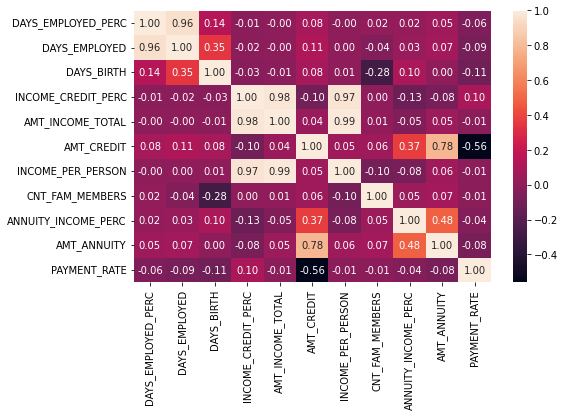

In [179]:
corr = train_df_processed[['DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED', 'DAYS_BIRTH', 'INCOME_CREDIT_PERC', 
                   'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'INCOME_PER_PERSON', 'CNT_FAM_MEMBERS', 
                   'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'PAYMENT_RATE']].corr()

fig, ax = plt.subplots(figsize=(8@, 5))
sns.heatmap(corr, annot=True, fmt='.2f')

In [46]:
train_df_processed[['DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_BIRTH', 'TARGET']].corr()['TARGET'].sort_values(ascending=False)

TARGET                1.000000
DAYS_BIRTH            0.089391
DAYS_EMPLOYED_PERC   -0.062661
DAYS_EMPLOYED        -0.071994
Name: TARGET, dtype: float64

Visualisations

Corrélation entre DAYS_EMPLOYED et DAYS_EMPLOYED_PERC

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='DAYS_EMPLOYED_PERC'>

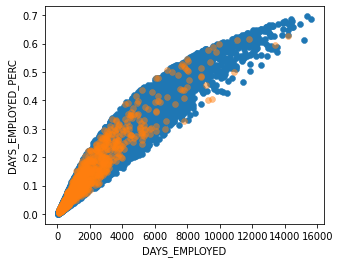

In [63]:
plt.figure(figsize = (5, 4))
sns.scatterplot(data=train_df_processed[train_df_processed.TARGET==0],
                x='DAYS_EMPLOYED',
                y='DAYS_EMPLOYED_PERC', 
                linewidths=0,
                edgecolor=None,
               )

sns.scatterplot(data=train_df_processed[train_df_processed.TARGET==1],
                x='DAYS_EMPLOYED',
                y='DAYS_EMPLOYED_PERC', 
                linewidths=0,
                edgecolor=None,
                alpha=0.5
               )



Corrélation entre DAYS_EMPLOYED_PERC et DAYS_BIRTH

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='DAYS_EMPLOYED_PERC'>

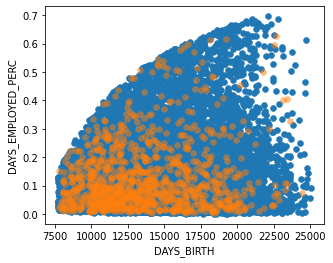

In [62]:
plt.figure(figsize = (5, 4))
sns.scatterplot(data=train_df_processed[train_df_processed.TARGET==0],
                x='DAYS_BIRTH',
                y='DAYS_EMPLOYED_PERC', 
                linewidths=0,
                edgecolor=None,
               )

sns.scatterplot(data=train_df_processed[train_df_processed.TARGET==1],
                x='DAYS_BIRTH',
                y='DAYS_EMPLOYED_PERC', 
                linewidths=0,
                edgecolor=None,
                alpha=0.5
               )


In [180]:
train_df_processed.drop(columns='DAYS_EMPLOYED', inplace=True)

train_df_processed.drop(columns = ['AMT_INCOME_TOTAL', 
                                   'INCOME_PER_PERSON'], inplace=True)

<AxesSubplot:>

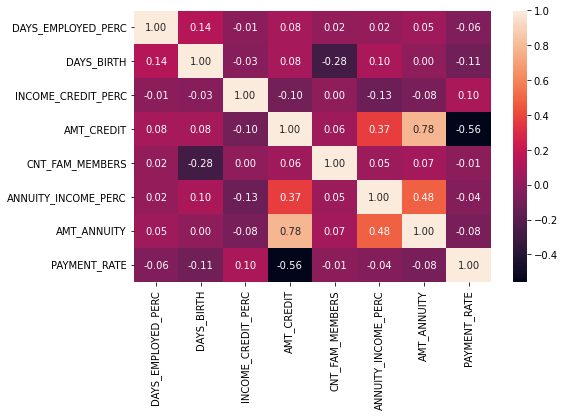

In [75]:
corr = train_df_processed[['DAYS_EMPLOYED_PERC', 'DAYS_BIRTH', 'INCOME_CREDIT_PERC', 
                           'AMT_CREDIT', 'CNT_FAM_MEMBERS', 
                           'ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'PAYMENT_RATE']].corr()

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(corr, annot=True, fmt='.2f')

In [182]:
corr = train_df_processed.corr()
corr.loc[corr['TARGET'].isna(), "TARGET"]

FLAG_MOBIL         NaN
FLAG_DOCUMENT_2    NaN
FLAG_DOCUMENT_10   NaN
FLAG_DOCUMENT_12   NaN
Name: TARGET, dtype: float64

In [183]:
flag_cols = corr.loc[corr['TARGET'].isna(), "TARGET"].index
train_df_processed[flag_cols].head()

,FLAG_MOBIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_10,FLAG_DOCUMENT_12
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [184]:
train_df_processed.drop(columns=flag_cols, inplace=True)

<AxesSubplot:>

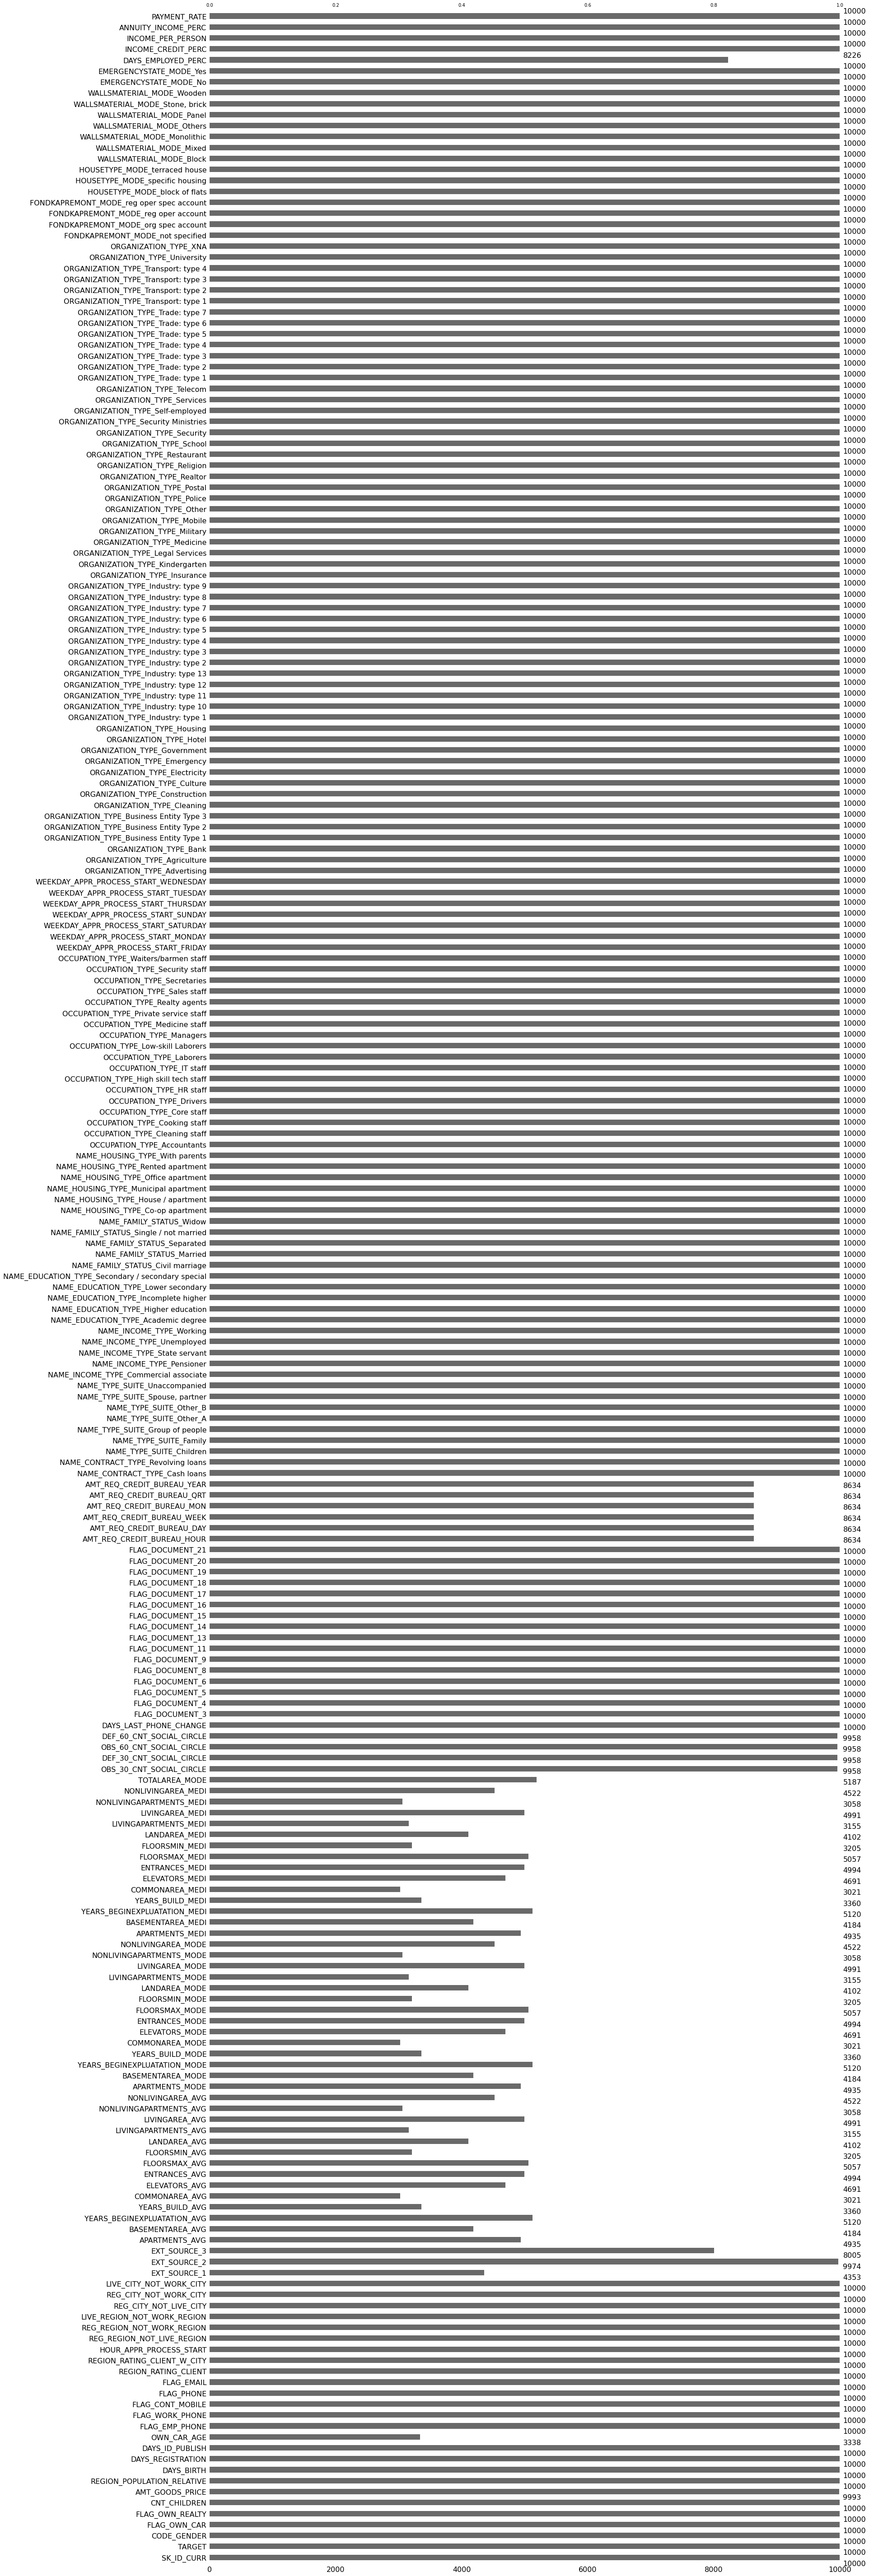

In [12]:
msno.bar(train_df_processed)

In [185]:
ratio_nna = train_df_processed.notna().sum()/train_df_processed.shape[0]
to_drop = ratio_nna[ratio_nna<0.75].index
train_df_processed.drop(columns=to_drop, inplace=True)
train_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 192 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: float64(23), int64(7), uint8(162)
memory usage: 5.9 MB


In [214]:
isna_s = train_df_processed.isna().sum()
isna_cols = isna_s[isna_s!=0].index
train_df_processed[isna_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AMT_GOODS_PRICE             14989 non-null  float64
 1   EXT_SOURCE_2                14960 non-null  float64
 2   EXT_SOURCE_3                11994 non-null  float64
 3   OBS_30_CNT_SOCIAL_CIRCLE    14939 non-null  float64
 4   DEF_30_CNT_SOCIAL_CIRCLE    14939 non-null  float64
 5   OBS_60_CNT_SOCIAL_CIRCLE    14939 non-null  float64
 6   DEF_60_CNT_SOCIAL_CIRCLE    14939 non-null  float64
 7   AMT_REQ_CREDIT_BUREAU_HOUR  12974 non-null  float64
 8   AMT_REQ_CREDIT_BUREAU_DAY   12974 non-null  float64
 9   AMT_REQ_CREDIT_BUREAU_WEEK  12974 non-null  float64
 10  AMT_REQ_CREDIT_BUREAU_MON   12974 non-null  float64
 11  AMT_REQ_CREDIT_BUREAU_QRT   12974 non-null  float64
 12  AMT_REQ_CREDIT_BUREAU_YEAR  12974 non-null  float64
 13  DAYS_EMPLOYED_PERC          123

que des decimaux. On peut a priori utiliser l'imputation par la moyenne

**Test de différentes méthodes d'imputation**

In [26]:
df = train_df_processed.dropna(how='any')
df.shape

(9828, 190)

Nb samples:9828, Nb features:189
Evaluating with strategy = mean...
Evaluating with strategy = median...
Evaluating with estimator = BayesianRidge...
Evaluating with estimator = KNeighborsRegressor...


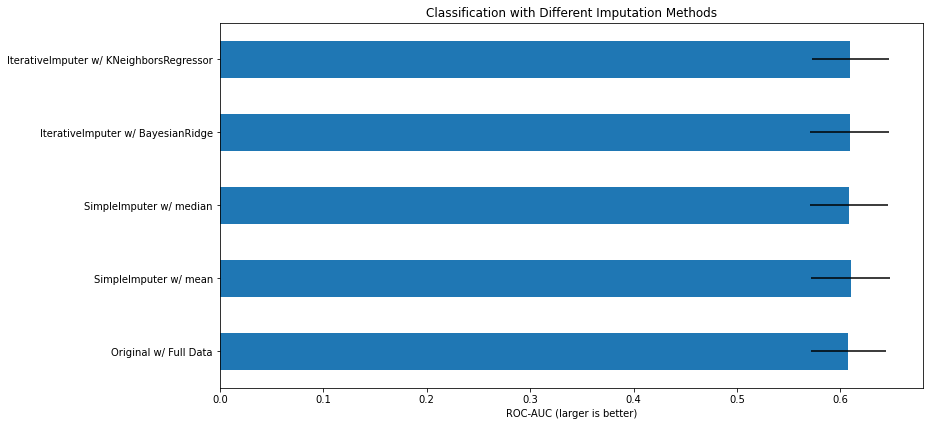

In [27]:
X = np.asarray(df.drop(columns='TARGET'))
y = np.asarray(df.TARGET)

scores = imputer_selection(X, y)

In [28]:
scores

Original SimpleImputer           IterativeImputer                    
  Full Data          mean    median    BayesianRidge KNeighborsRegressor
0  0.610292      0.614016  0.610957         0.608652            0.612393
1  0.629596      0.632001  0.631914         0.634886            0.631590
2  0.636059      0.635871  0.637176         0.637545            0.635057
3  0.617209      0.623495  0.617515         0.619302            0.623467
4  0.545700      0.543736  0.543252         0.543945            0.544631

Aucun différence majeure: on utilise fillna avec la stratégie 'mean'

In [215]:
train_df_processed.fillna(train_df_processed.mean(), inplace=True)

Standardisation

In [190]:
train_df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Columns: 192 entries, SK_ID_CURR to PAYMENT_RATE
dtypes: float64(23), int64(7), uint8(162)
memory usage: 5.9 MB


In [191]:
int64_cols = [col for col in train_df_processed.columns if train_df_processed[col].dtype=='int64']
train_df_processed[int64_cols].head()

,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START
0,100002,0,9461,-2120,2,2,10
1,100003,0,16765,-291,1,1,11
2,100004,0,19046,-2531,2,2,9
3,100006,0,19005,-2437,2,2,17
4,100007,0,19932,-3458,2,2,11


In [193]:
train_df_processed[int64_cols].describe()

,SK_ID_CURR,CNT_CHILDREN,DAYS_BIRTH,DAYS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,108743.871467,0.420533,15997.521333,-2976.009667,2.050933,2.030400,12.079400
std,5044.401339,0.724882,4345.674162,1512.298805,0.510382,0.504935,3.235974
min,100002.000000,0.000000,7689.000000,-6228.000000,1.000000,1.000000,1.000000
25%,104376.500000,0.000000,12335.750000,-4289.000000,2.000000,2.000000,10.000000
50%,108745.500000,0.000000,15749.000000,-3219.000000,2.000000,2.000000,12.000000
75%,113105.250000,1.000000,19589.250000,-1696.000000,2.000000,2.000000,14.000000
max,117513.000000,8.000000,25160.000000,0.000000,3.000000,3.000000,23.000000


In [192]:
uint_cols = [col for col in train_df_processed.columns if train_df_processed[col].dtype=='uint8']

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1,0,0,0,1,0,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,1,0,1,1,0,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
cols_to_scale = [col for col in train_df_processed.columns if (col not in uint_cols) & (col!='SK_ID_CURR')]

scaler = StandardScaler()
train_df_processed[cols_to_scale] = scaler.fit_transform(train_df_processed[cols_to_scale])

In [217]:
train_df_processed.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1,0,0,0,-0.58016,-0.482152,-0.166301,-0.511023,-0.141322,...,0,0,1,0,1,0,-0.739199,0.049914,-0.623541,0.325578
1,100003,0,1,0,1,-0.58016,1.713327,0.594894,1.584249,-1.247741,...,0,0,0,0,1,0,-0.710140,-0.117433,-0.516658,-1.158706
2,100004,0,0,1,0,-0.58016,-1.154475,-1.408694,-1.092370,-0.777114,...,0,0,0,0,0,0,-1.195829,0.051050,-0.852964,-0.155705
3,100006,0,1,0,0,-0.58016,-0.714632,0.178791,-0.656360,-0.923066,...,0,0,0,0,0,0,0.022264,0.011569,0.398657,1.856477
4,100007,0,0,0,0,-0.58016,-0.218759,-0.362518,-0.075013,0.573717,...,0,0,0,0,0,0,-0.039319,-0.101174,-0.018241,-0.486007


Pipeline de prédiction

<AxesSubplot:>

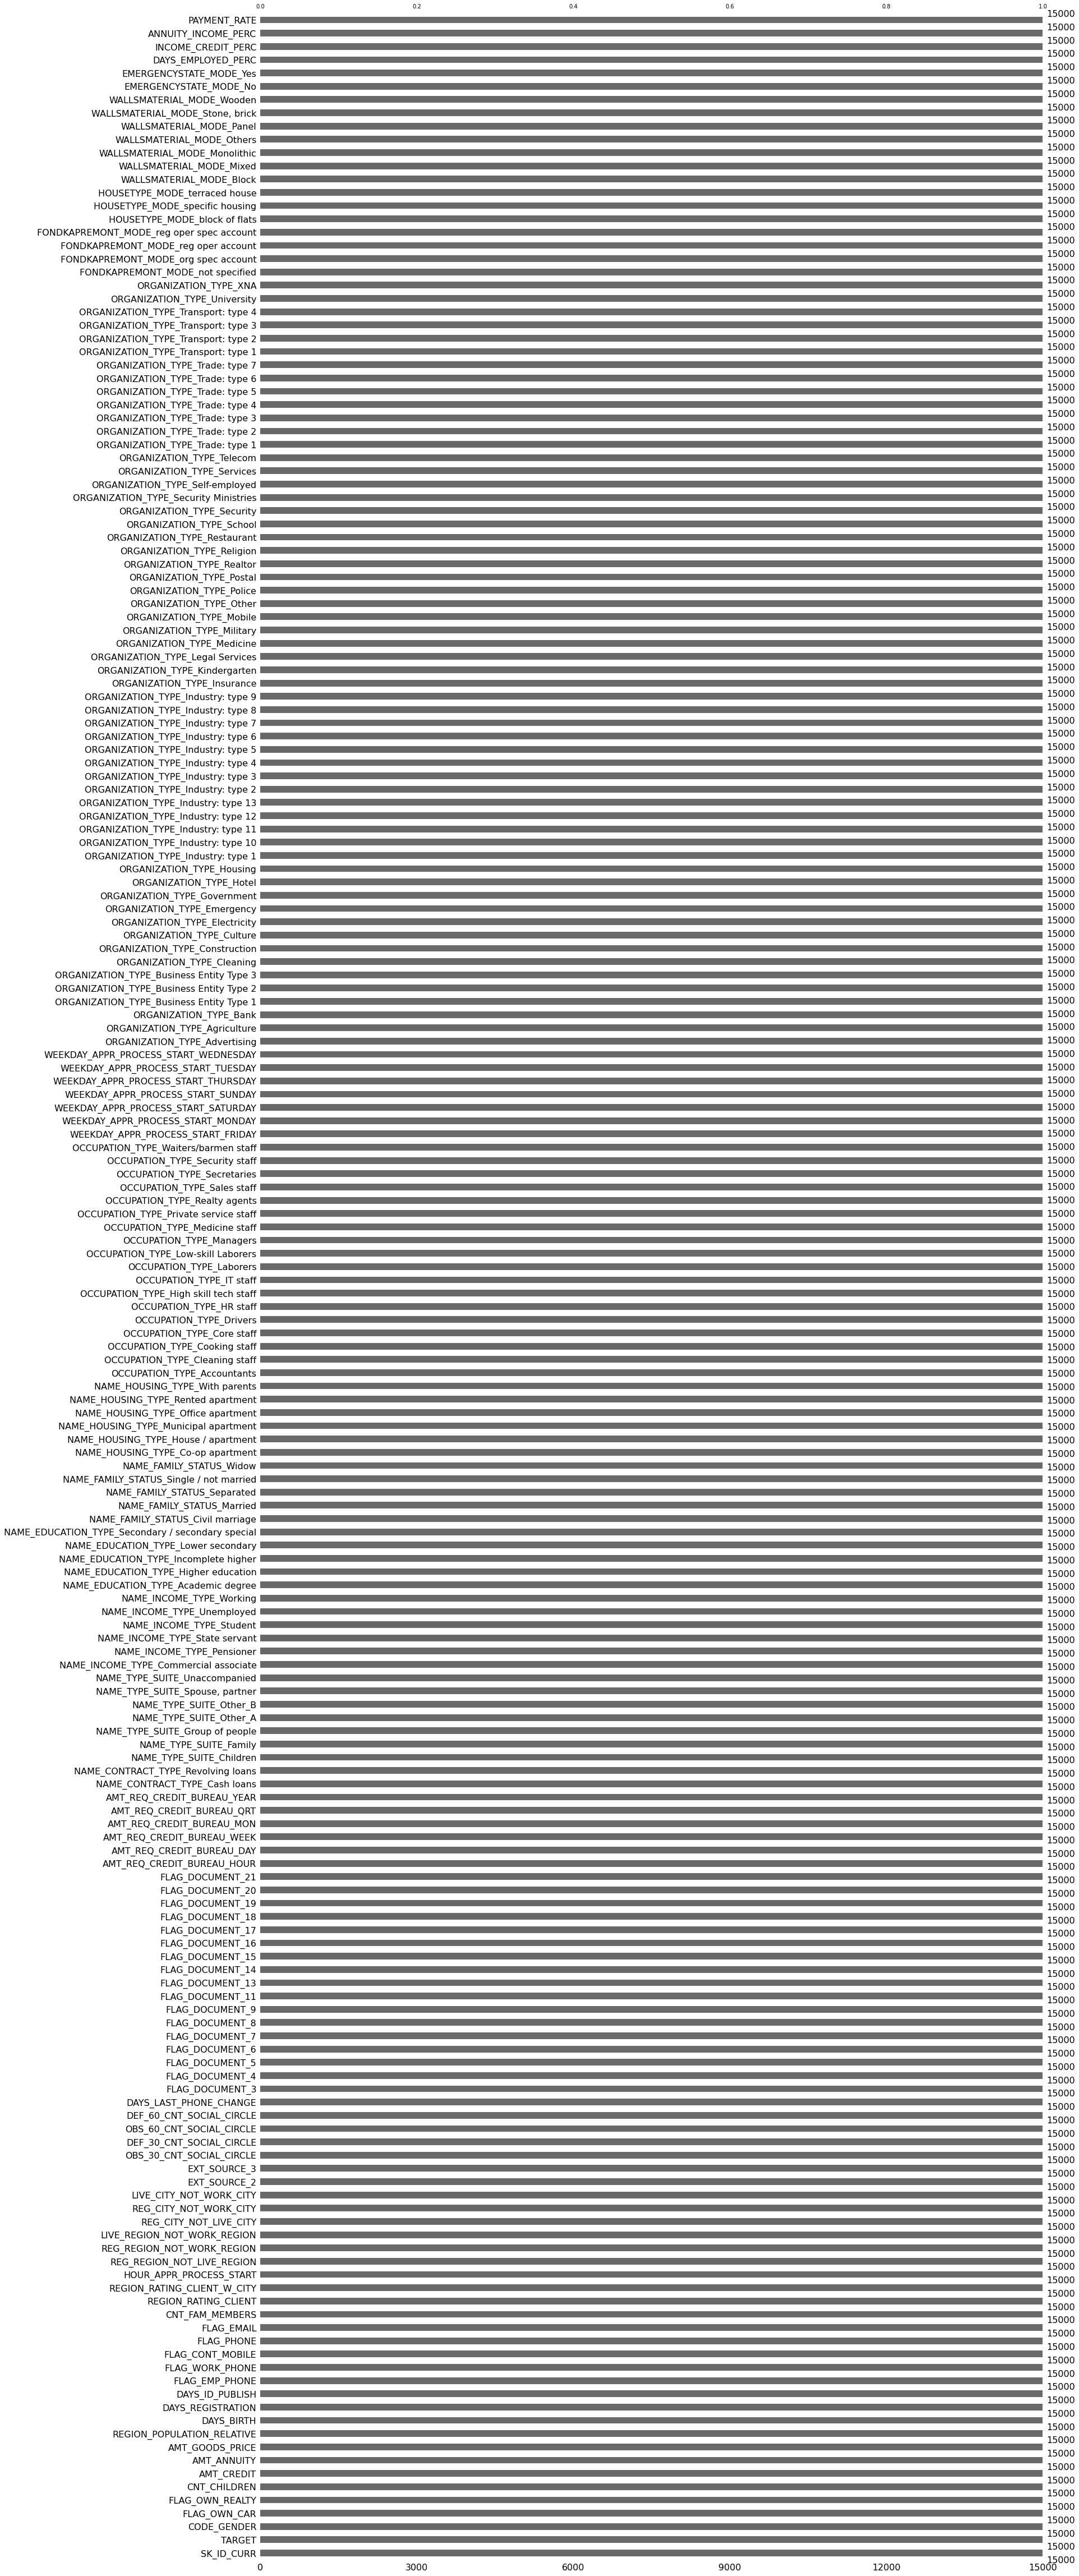

In [218]:
msno.bar(train_df_processed)

In [219]:
# Séparation prédicteurs - cible, entraînement-test. Préparation du pipeline
X = train_df_processed.drop(columns=['SK_ID_CURR','TARGET'])
y = train_df_processed.TARGET

# Nested cross-validation pour la validation du (des) hyperparamètre(s) par GridSearch
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

# Hyperparamètre(s) à optimiser
param_grid = {"n_estimators" : [100, 500], 
              "max_depth" : [None, 5, 30], 
              "max_features" : ['auto', "sqrt"]}    
    

model = RandomForestClassifier()
# Régression avec sélection d'(des)hyperparamètre(s) par validation croisée
regr = GridSearchCV(
model,            # modèle
param_grid,     # hyperparamètres à tester
cv=inner_cv,    # nombre de folds de validation croisée
scoring='roc_auc',   # score à optimiser
return_train_score=True,
refit='roc_auc',
)

# Séparation entraînement-test. Le jeu X_train est lui-même séparé en jeu d'entraînement et de validation
# lors de la recherche sur grille.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

# Optimisation de l'estimateur sur le jeu d'entraînement
regr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("\nMeilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(regr.best_params_)

# Performance sur le jeu d'entraînement
print("\nPerformance sur le jeu d'entraînement' : {:.3f}".format(regr.score(X_train, y_train)))

# Performance en généralisation du meilleur modèle sur le jeu de test
#y_pred = regr.predict(X_test)
#print("Performance en généralisation sur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 500}

Performance sur le jeu d'entraînement' : 0.844


### bureau and bureau_balance

In [ ]:
bb_df = lgbmsf.bureau_and_balance(num_rows=NUM_ROWS)

In [ ]:
bb_df.head()

## previous_applications

In [ ]:
previous_app_df = lgbmsf.previous_applications(num_rows=NUM_ROWS)
previous_app_df.head()

## pos_cash

In [ ]:
poc_cash = lgbmsf.pos_cash(num_rows=NUM_ROWS)
poc_cash.head()

## installment_payments

In [ ]:
installment_p_df = lgbmsf.installments_payments(num_rows=NUM_ROWS)
installment_p_df.head()

## credit_card balance

In [ ]:
cc_balance = lgbmsf.credit_card_balance(num_rows=NUM_ROWS)
cc_balance.head()

## sample_submission

In [ ]:
results = pd.read_csv('./data/sample_submission.csv')
results.head()

Ok.

### Definitions des tables

**HomeCredit_columns_description.csv**

In [ ]:
application_train = pd.read_csv('./data/HomeCredit_columns_description.csv')
HomeCredit_df.drop

## Classes déséquilibrées

In [ ]:
# Construction du dataframe "global"
data = lgbmsf.join_df(NUM_ROWS)
data.info()

## Target

In [ ]:
data.TARGET.unique()

In [ ]:
data['TARGET'].value_counts()

Le jeu de données est donc bien déséquilibré

Essayer de proposer un premier modèle - baseline: pourquoi pas une simpe regression logistique?
Il faudra diminuer le nombre de variables en entrée: on a 765 colonnes
--> compliqué à cause du mix variables continues et variables catégorielles.
Combien de variables catégorielles?


Colonnes liées entre elles?

_DAYS_EMPLOYED, DAYS_EMPLOYED_PERC, DAYS_BIRTH_

In [ ]:
cols = ['DAYS_EMPLOYED_PERC', 'DAYS_EMPLOYED', 'DAYS_BIRTH']
df = data[cols]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')

_INCOME_CREDIT_PERC, AMT_INCOME_TOTAL, AMT_CREDIT_

In [ ]:
cols = ['INCOME_CREDIT_PERC', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']
df = data[cols]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')

In [ ]:
cols = ['INCOME_PER_PERSON', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']
df = data[cols]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')

In [ ]:
cols = ['ANNUITY_INCOME_PERC', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']
df = data[cols]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')

In [ ]:
cols = ['PAYMENT_RATE', 'AMT_ANNUITY', 'AMT_CREDIT']
df = data[cols]
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f')